# ***MAKEMORE: BIGRAM NLP MODEL***

### Importing Libs

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np

### Reading list of names (all lowered already)

In [ ]:
words = open("names.txt", "r").read().splitlines()
words[:10]

In [6]:
print(f"Min: {len(min(words, key=len))}")
print(f"Max: {len(max(words, key=len))}")

Min: 2
Max: 15


## Creating Bigrams
A bigrams are all 2 consecutive chars inside a word ("victor" = ["vi", "ic", "ct", "to", "or"]) <br/>
We're also adding start '<\S>' and end '<\E>' chars

In [7]:
b = {}
for w in words[:]:
    chs = ["<S>"] + list(w) + ["<E>"]
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

In [8]:
sorted(b.items(), key=lambda kv: -kv[1])[:10]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963)]

### Creating the **N** Matrix: save the count of every bigram on all names

In [9]:
N = torch.zeros(27, 27, dtype=torch.int32)

### Special char ".": used on start and on end of the names

In [ ]:
chars = sorted(list(set(''.join(words))))
# String to Integer dict mapper
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi["."] = 0 # first index is reserved for start/end token
itos = {i:s for s, i in stoi.items()} # Integer to String dict mapper

#### Counting the bigrams:

In [11]:
for w in words[:]:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

### Heatmap of bigram occurrencies:

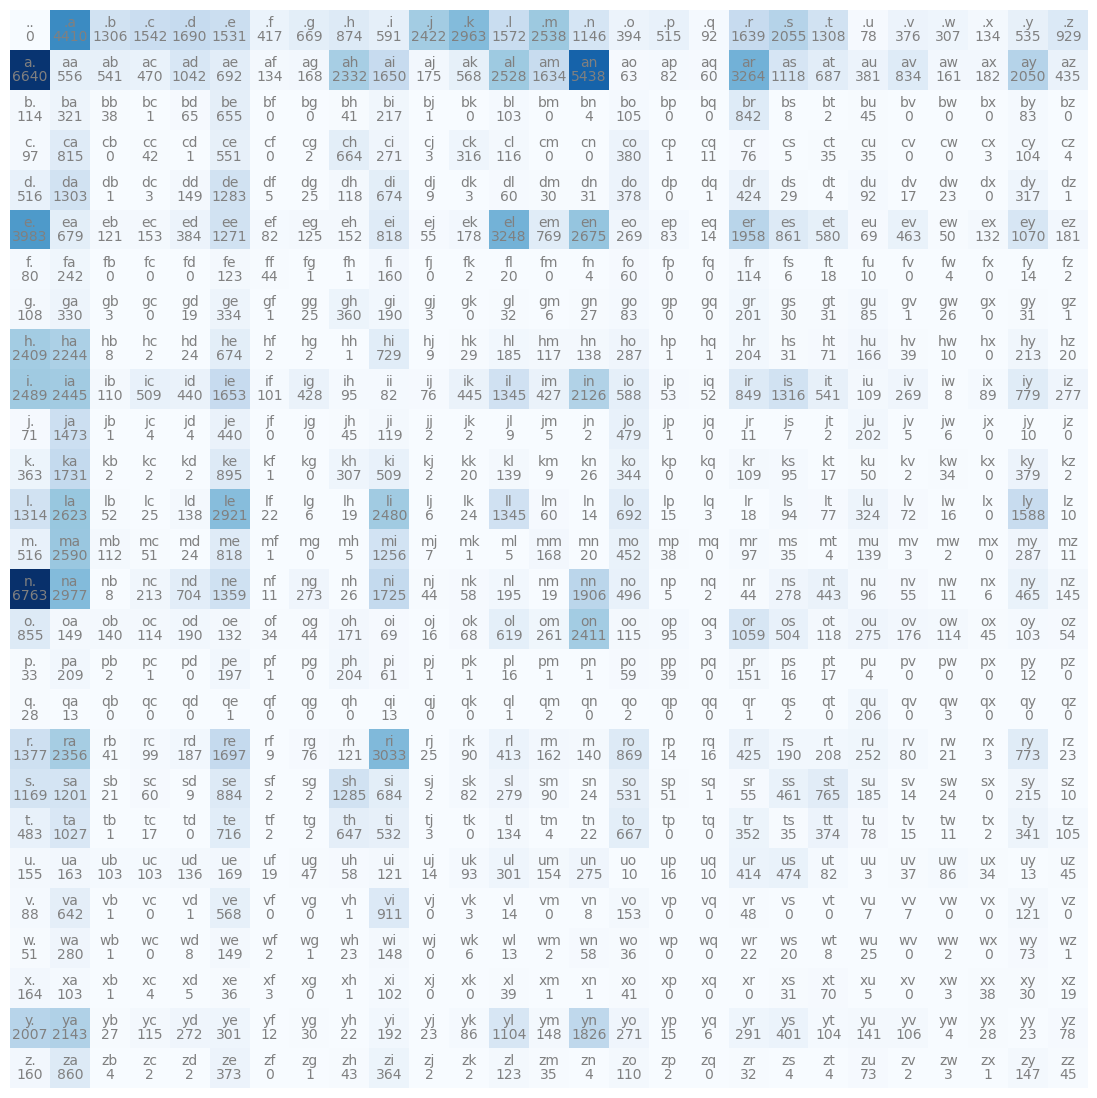

In [20]:
plt.figure(figsize=(14,14))
plt.imshow(N, cmap="Blues")
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color="gray")
plt.axis("off")
plt.show()

### Converting the first N row into probabilities and sampling

In [27]:
p = N[0].float()
p /= p.sum()

In [28]:
g = torch.Generator().manual_seed(42)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'y'

Example on row to convert row values into probs

In [33]:
g = torch.Generator().manual_seed(42)
p = torch.rand(3, generator=g)
p = p / p.sum()
print(f'{p=}')
print(f'{p.sum()=}')

p=tensor([0.4047, 0.4197, 0.1756])
p.sum()=tensor(1.0000)


### Calculating the probablity of bigrams for rows

In [34]:
P = (N + 1).float() # Add so that we don't have zero probs
P = P / P.sum(dim=1, keepdim=True)

### Creating Sample artificial names based on the bigrams probs

In [ ]:
g = torch.Generator().manual_seed(42)
for i in range(20):
    out = []
    ix = 0
    while True:
        p = P[ix]       
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))
        

ya.
syahavilin.
dleekahmangonya.
tryahe.
chen.
ena.
da.
amiiae.
a.
keles.
ly.
a.
oy.
asityi.
pepolannezale.
shahlamion.
nacelucyanarivieriaquten.
kigshmole.
ei.
tonylyan.


### Calculating how "good" the model is based on the log of the likelihood
- GOAL: Maximize the log likelihood
- Same as minimizing the neg log likelihood
- Probs are always lower than 1, so all logprobs are negative
- The closer the prob is to 1, the closer the logprob is to 0


In [26]:
log_likelihood: float = 0.0
n = 0

for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        
print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n=}')

log_likelihood=tensor(-559891.7500)
nll=tensor(559891.7500)
nll/n=tensor(2.4541)


## BiGrams Approach with NN

In [92]:
# create the training set (x,y)
# based on the char x, predict the next char y in the bigram
xs, ys = [], []
for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()

## Using One Hot Encoding on the input of the NN Model

In [103]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float() #inputs of the NN should be float
xenc[0:2]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [104]:
xenc.shape

torch.Size([228146, 27])

### Usings Logits and Softmax to interpret outputs as probs

In [105]:
#(5, 27) @ (27, 27) => (5, 27)
# Intialize random weights
g = torch.Generator().manual_seed(42)
W = torch.randn((27, 27), generator=g)
# Matrix Mult in Pytorch
logits = xenc @ W # Log counts
# Softmax
counts = logits.exp() #Equivalent N
probs = counts / counts.sum(dim=1, keepdim=True) #Equivalent P
probs[0]

tensor([0.1230, 0.0793, 0.0441, 0.0022, 0.0353, 0.0052, 0.0172, 0.0036, 0.0084,
        0.0932, 0.0121, 0.0044, 0.0087, 0.0102, 0.0083, 0.0384, 0.0926, 0.0153,
        0.0109, 0.0278, 0.0084, 0.0527, 0.0399, 0.0962, 0.0644, 0.0655, 0.0330])

## Example

In [106]:
nlls = torch.zeros(5)
for i in range(5):
    # i-th bigram
    x = xs[i].item()
    y = ys[i].item()
    print('-'*10)
    print(f'bigram example: {itos[x]}{itos[y]} (indexes {x}, {y})')
    print(f'input to the neural net: {x}')
    print(f'output prob: {probs[i]}')
    print(f'label (true next char): {y}')
    p = probs[i, y]
    print(f'prob of true next char: {p}')
    logp = torch.log(p)
    print(f'log prob of true next char: {logp}')
    nll = -logp
    print(f'nll:', nll.item())
    nlls[i] = nll
    
print('='*10)
print(f'average nll: {nlls.mean().item()}')


----------
bigram example: .e (indexes 0, 5)
input to the neural net: 0
output prob: tensor([0.1230, 0.0793, 0.0441, 0.0022, 0.0353, 0.0052, 0.0172, 0.0036, 0.0084,
        0.0932, 0.0121, 0.0044, 0.0087, 0.0102, 0.0083, 0.0384, 0.0926, 0.0153,
        0.0109, 0.0278, 0.0084, 0.0527, 0.0399, 0.0962, 0.0644, 0.0655, 0.0330])
label (true next char): 5
prob of true next char: 0.005211981479078531
log prob of true next char: -5.256795406341553
nll: 5.256795406341553
----------
bigram example: em (indexes 5, 13)
input to the neural net: 5
output prob: tensor([0.0396, 0.0698, 0.0227, 0.0037, 0.0562, 0.0153, 0.0626, 0.0112, 0.0421,
        0.0084, 0.0581, 0.1125, 0.0951, 0.0292, 0.0181, 0.0107, 0.0247, 0.0316,
        0.0586, 0.0140, 0.1109, 0.0019, 0.0147, 0.0067, 0.0502, 0.0033, 0.0280])
label (true next char): 13
prob of true next char: 0.029176028445363045
log prob of true next char: -3.5344078540802
nll: 3.5344078540802
----------
bigram example: mm (indexes 13, 13)
input to the neural n

## Optimization with Gradient Descent

In [107]:
# Intialize random weights
g = torch.Generator().manual_seed(42)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [108]:
# Gradient Descent
lr = 10
for k in range(100):
    # Forward Step
    xenc = F.one_hot(xs, num_classes=27).float() #inputs of the NN should be float
    logits = xenc @ W # Log counts
    # Softmax
    counts = logits.exp() #Equivalent N
    probs = counts / counts.sum(dim=1, keepdim=True) #Equivalent P
    loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean() # L2 Regularization
    print(f'{loss=}')
    # Backward Step
    W.grad = None # Reset grads
    loss.backward()
    
    # Update params
    W.data += -lr * W.grad

loss=tensor(3.7065, grad_fn=<AddBackward0>)
loss=tensor(3.6319, grad_fn=<AddBackward0>)
loss=tensor(3.5642, grad_fn=<AddBackward0>)
loss=tensor(3.5021, grad_fn=<AddBackward0>)
loss=tensor(3.4449, grad_fn=<AddBackward0>)
loss=tensor(3.3919, grad_fn=<AddBackward0>)
loss=tensor(3.3427, grad_fn=<AddBackward0>)
loss=tensor(3.2970, grad_fn=<AddBackward0>)
loss=tensor(3.2547, grad_fn=<AddBackward0>)
loss=tensor(3.2154, grad_fn=<AddBackward0>)
loss=tensor(3.1791, grad_fn=<AddBackward0>)
loss=tensor(3.1456, grad_fn=<AddBackward0>)
loss=tensor(3.1146, grad_fn=<AddBackward0>)
loss=tensor(3.0860, grad_fn=<AddBackward0>)
loss=tensor(3.0596, grad_fn=<AddBackward0>)
loss=tensor(3.0351, grad_fn=<AddBackward0>)
loss=tensor(3.0123, grad_fn=<AddBackward0>)
loss=tensor(2.9911, grad_fn=<AddBackward0>)
loss=tensor(2.9712, grad_fn=<AddBackward0>)
loss=tensor(2.9526, grad_fn=<AddBackward0>)
loss=tensor(2.9352, grad_fn=<AddBackward0>)
loss=tensor(2.9188, grad_fn=<AddBackward0>)
loss=tensor(2.9034, grad_fn=<Add

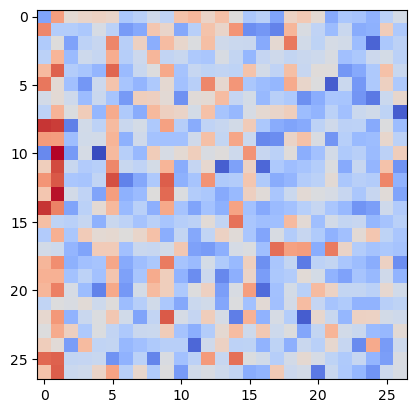

In [109]:
plt.imshow(W.detach().numpy(), cmap="coolwarm")

## Sampling from the model

In [115]:
for i in range(5):
    out = []
    ix = 0
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W #logits preds
        counts = logits.exp() #softmax
        probs = counts / counts.sum(1, keepdims=True) # softmax
        ix = torch.multinomial(probs, num_samples=1).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

sdiyzzgwudeliusha.
beliyanlhjemamavlez.
onur.
onierriwderadf.
la.
